![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
# QuantConnect Alpha Streams
#### Licensed Under QuantConnect Platform Service Agreement v1.0. Copyright QuantConnect 2018.
#### For more information; see the Open API Specification of Alpha Streams: https://app.swaggerhub.com/apis/QuantConnect/Alpha/0.4

## Introduction

QuantConnect Alpha Streams allows quantiative funds to search a database of algorithm authors; and instantly license the authors' strategies (`Alpha`). The license agreements and fee structure is already prenegotiated, and the standardized backtesting and live trading infrastructure can give funds confidence in the algorithm results. Upon licensing an Alpha the insights/signals are instantly delivered to the fund in realtime.

## Terminology
 - `Alpha`     - Strategy for licensing.
 - `Author`    - QuantConnect member and creator of the Alpha. 
 - `Insight`   - Trade signal from an algorithm; consisting of an asset, direction, magnitude and confidence.
 - `Project`   - Properties of the project which submitted the `Alpha` 

## SDK Demonstration


### 1. Setup the SDK: Login with Client Credentials
We have written a full abstraction and SDK for the API which you can quickly import into your investment process. To start create a new instance of the `AlphaStreamClient` with your clientId and token.

In [1]:
# Prepare the import. This step is needed of AlphaStream is not installed yet\n",
try:
    import AlphaStream
except ImportError:
    import os, sys
    from os.path import dirname
    sys.path.append(dirname(os.getcwd()))

In [2]:
# Import Python SDK Client Library 
from AlphaStream import AlphaStreamRestClient 

# Define the clientId and API access token:
clientId  = ""
token     = ""

# Create a new instance of the client module:
client = AlphaStreamRestClient(clientId, token)

### 2. Listing all Alpha Strategies For Licensing
Listing all alpha ids so you can maintain a dictionary and detect programatically when a new alpha is added to the API.

In [3]:
# List all alphas:
print(client.GetAlphaList()[-5:])

['8d86e48e694cffa981a4c1dd3', '337c632595132dea8da00e49b', '830dd81619e5559cd2e64e625', 'b84a5a6984ec51990948a9d09', '691b72877cf58da1862b721aa']


### 3. Searching Alpha Strategies For Licensing
The primary aim of the Alpha Streams API is to quickly search for Alpha which matches your criteria. This criteria is unique to your fund and might include such aspects as: asset class, time horizon, risk adjusted return or market depth. Alpha Streams API aims to give you flexibility you need to locate suitable algorithms.

In [4]:
# Submit Search:
alphas = client.SearchAlphas( includedTags = ['mean reversion'], excludedTags = ['single selection'] )

# Display some information on the algorithms:
for a in alphas[:5]:
    print(f"Alpha: id: {a.Id} Project: '{a.Name}' Tags : ${a.Tags}")

Alpha: id: 5d07d02ba5e3559253480bc12 Project: 'Intraday Penny Bear' Tags : $[]
Alpha: id: 651af28ca2fcd562275434680 Project: 'Quick Correction Exploit' Tags : $[]
Alpha: id: bef1427ef8d91f656a6c449f3 Project: 'Leveraged Index Investing' Tags : $[]
Alpha: id: c9f028d9f8337992c66fab0e8 Project: 'Leveraged Index Investing' Tags : $[]
Alpha: id: d3b4eb9ad9d12bb61efc7255a Project: 'long short panics' Tags : $[]


#### 3.1 Create a new bid
Once you found an interesing alpha stream, you can make a bid

In [5]:
from datetime import datetime, timedelta

client.CreateBid(
    alphaId = 'd0fc88b1e6354fe95eb83225a',
    bid = 3,
    allocation = 10000,
    period = 28,
    good_until = datetime.utcnow() + timedelta(1)
)

'Bid price was successfully created.'

### 4. Pull Information on an Alpha By Specific AlphaId
You can fetch information on an alpha by its associated id with the `/alpha/{id}` API endpoint.

In [6]:
# Prospective / Test Alpha Id:
alphaId = "d0fc88b1e6354fe95eb83225a"
alpha = client.GetAlphaById( alphaId )

# Print out the Alpha data:
print(f'''Alpha Id: {alpha.Id}
    Project: {alpha.Name}
    ExclusiveAvailable: {alpha.ExclusiveAvailable}
    Listed: {alpha.ListedTime}''')

Alpha Id: d0fc88b1e6354fe95eb83225a
    Project: Intraday Reversal Mean Reversion
    ExclusiveAvailable: 1
    Listed: 2019-02-11 02:38:05


### 5. Get Last 5 Insights of an Alpha
All historical insights of an Alpha are recorded in a database. Insights are generated `in sample`, `out of sample` or in `live trading`. Using these insights you can perform your own backtests with your own fill and slippage models to see how the strategy would have performed with your execution.

In [7]:
# Request Insights for the Previously Alpha
insights = client.GetAlphaInsights( alphaId, start = 1760 )

# Take Top 5:
for i in insights[-5:]:
    magnitude = "" if i.Magnitude is None else " by {i.Magnitude:.2%}"
    print(f"{i.CreatedTime} Alpha {i.Source} {i.Type} insight for {i.Ticker:<10} going {i.Direction}{magnitude} over the next {i.Period}s")

2020-08-04 19:00:00 Alpha out of sample price insight for eurusd     going up over the next 60s
2020-08-05 14:00:00 Alpha out of sample price insight for eurusd     going down over the next 18060s
2020-08-05 17:00:00 Alpha out of sample price insight for eurusd     going up over the next 7260s
2020-08-05 17:00:00.001100 Alpha live trading price insight for EURUSD     going up over the next 7259.999s
2020-08-06 17:00:00 Alpha out of sample price insight for eurusd     going down over the next 7260s


### 6. Get First 5 Orders of an Alpha
All historical orders of an Alpha are recorded in a database. Orders are generated `in sample`, `out of sample` or in `live trading`. Using these orders you can perform your own backtests with your own fill and slippage models to see how the strategy would have performed with your execution.

In [ ]:
orders = client.GetAlphaOrders("21a2a00a097117a84788c1434", start = 0)
for o in orders[:5]:
    print(f'{o}\n')

### 7. Seach Alpha Streams by Author Details
Knowing who created the Alpha can be an important search tool to improve your filtering. Participating Author information can be searched in a similar manner to the Alpha Search. Each supplied criteria is a logical AND on the query.

In [8]:
languages = ["C#"]

authors = client.SearchAuthors( languages = languages, location = "Virginia" )

print(f"Located {len(authors)} authors matching your criteria.")

for a in authors[:5]:
    print(f"Alpha Stream Author {a.Id[:5]:>5} is from {a.Location}. Signed up {a.SignUpTime} and codes in {a.Language}")

Located 41 authors matching your criteria.
Alpha Stream Author 2b255 is from  Virginia, US. Signed up 2016-09-28 17:20:14 and codes in C#
Alpha Stream Author 1ba2f is from  Virginia, US. Signed up 2013-10-17 00:27:36 and codes in C#
Alpha Stream Author f1b63 is from Ashburn, Virginia, US. Signed up 2013-06-18 09:26:03 and codes in C#
Alpha Stream Author 49f56 is from  Virginia, US. Signed up 2014-05-09 21:10:53 and codes in C#
Alpha Stream Author b66b9 is from  Virginia, US. Signed up 2014-08-02 10:04:21 and codes in C#


### 8. Fetch Detailed Information on a Specific Author
The API allows you to fetch detailed information on a specific author by the hash-id.

In [9]:
# Author to fetch profile information about:
authorId = '2b2552a1c05f83ba4407d4c32889c367'

# Submit request for more information:
author = client.GetAuthorById(authorId)

# Print out the Alpha data:
print(f'''Author Id: {author.Id[:5]}
    Biography: {author.Biography[:50]}...
    Projects: {author.Projects}
    Language: {author.Language}
    Signed Up: {author.SignUpTime}
    Location: {author.Location}''')

Author Id: 2b255
    Biography: This is an alpha developer profile for the QuantCo...
    Projects: 491
    Language: C#
    Signed Up: 2016-09-28 17:20:14
    Location:  Virginia, US


### 9. Stream Insights from An Alpha
Finally once analysed and subscribed to an Alpha - you can pull down the individual insights with the streaming socket connection. This is to use the insights in realtime in your fund management.

In [10]:
# Import the streaming client helper library
from AlphaStream.Models import Insight
from AlphaStream.AlphaStreamEventClient import AlphaStreamEventClient

# Configure authentication details
user = "demo-api"
password = "demo"
ipaddress = "35.231.13.1"
virtualhost = "demo-client"
exchange = "QCAlphaExchange_Demo-Client"
alphaId = "31ac5498164db7341b041a732"

# Subscribe to the Alpha at QuantConnect.com so we can stream the Insights

# Create the streaming client tool:
streamClient = AlphaStreamEventClient(user, password, ipaddress, virtualhost, exchange)

print("Streaming insights for 60 seconds... ")

# StreamSynchronously pulls down Insights for a minimum timeout in a blocking manner.
for i in streamClient.StreamSynchronously( alphaId, timeout=60 ):
    if isinstance(i, Insight):
        print(i)

print("Streaming completed.")

# Unsubscribe from the Alpha so we don't continue licensing it

Streaming insights for 60 seconds... 
Streaming completed.


### 10. Stream Orders from An Alpha
You can also pull down the individual orders with the streaming socket connection. This is to use the orders in realtime in your fund management.

In [11]:
from AlphaStream.Models import Order

# Select Alpha to stream
alphaId = "21a2a00a097117a84788c1434"

# Create the streaming client tool:
streamClient = AlphaStreamEventClient(user, password, ipaddress, virtualhost, exchange)

# Subscribe to the Alpha at QuantConnect.com so we can stream the Insights

print("Streaming orders for 20 seconds... ")

# StreamSynchronously pulls down Insights for a minimum timeout in a blocking manner.
for i in streamClient.StreamSynchronously( alphaId, timeout=20 ):
    if isinstance(i, Order):
        print(f'{i}\n')

print("Streaming completed.")

# Unsubscribe from the Alpha so we don't continue licensing it

Streaming orders for 20 seconds... 
Streaming completed.


### 11. Get Alpha Errors
See what runtime errors the Alpha has experienced to understand its stability in live trading.

In [12]:
alphaId = "c98a822257cf2087e37fddff9"

errors = client.GetAlphaErrors(alphaId, start = 0)

# Take Top 5:
for i in errors[:5]:
    print(f"Error at {i.Time}, error message: {i.Error[:10]}, stacktrace: {i.Stacktrace[:10]}") 

Error at 2019-04-29 13:48:00, error message: Algorithm., stacktrace: System.Exc
Error at 2019-05-31 14:30:01, error message: Runtime Er, stacktrace: 


### 12. Get the equity curve on an Alpha

Get the equity curve of an Alpha, including both backtesting and live-trading. Helpful for understanding NAV correlation and visualization.

In [13]:
import matplotlib.pyplot as plt
alphaId = "d0fc88b1e6354fe95eb83225a"
equity = client.GetAlphaEquityCurve(alphaId)
print(equity.head())
print(equity.tail())

                        equity     sample
time                                     
2015-01-01 23:00:00  1000000.0  in sample
2015-01-02 22:00:00   998854.3  in sample
2015-01-04 23:00:00   998854.3  in sample
2015-01-05 23:00:00  1001529.7  in sample
2015-01-06 23:00:00   999041.5  in sample
                            equity        sample
time                                            
2021-02-07 23:50:01  861335.748579  live trading
2021-02-08 23:50:01  861592.496217  live trading
2021-02-09 23:50:02  861592.496217  live trading
2021-02-10 23:50:01  861592.496217  live trading
2021-02-11 17:00:00  861592.496217  live trading


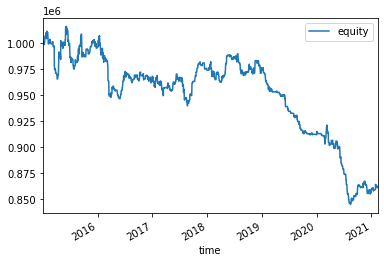

In [14]:
equity.drop('sample', axis=1).plot()
plt.show()

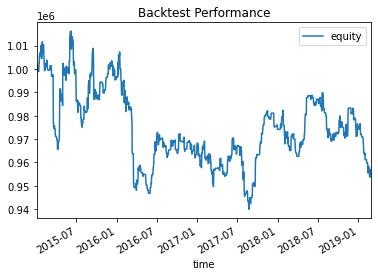

In [15]:
equity.loc[equity['sample'] == 'in sample'].drop('sample', axis=1).plot()
plt.title('Backtest Performance')
plt.show()

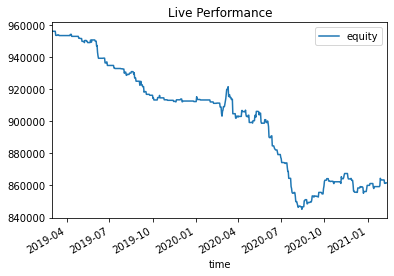

In [16]:
equity.loc[equity['sample'] == 'live trading'].drop('sample', axis=1).plot()
plt.title("Live Performance")
plt.show()

### 13. Create a conversation thread.
Start a conversation with the author(s) of the alpha via email. Quickly solve reconciliation issues or design automated filter questions.    

In [17]:
client.CreateConversation(
    alphaId = "d0fc88b1e6354fe95eb83225a",
    email = "you@your-company.com",
    message = "Hello World!",
    subject = "Alpha Conversation",
    cc = "bot1@your-company.com, bot2@your-company.com, bot2@your-company.com"
)

'Conversation thread was successfully created.'

### 14. Decode Symbol string.
Symbol represents a unique security identifier. This is made of two components, the unique SID and the Value. The value is the current ticker symbol while the SID is constant over the life of a security.
The SID contains information about a specific security. This includes the symbol and other data specific to the SecurityType.

In [18]:
from AlphaStream.Models import Symbol
string_symbols = ['SPY R735QTJ8XC9X', 'AAPL R735QTJ8XC9X', 'EURUSD 5O', 'USDJPY 8G', 'WTICOUSD 8I', 'BTCUSD XJ', 'ED XKDEAL18BYP5' ]
for string_symbol in string_symbols:
    symbol = Symbol(string_symbol)
    print(f'Ticker: {symbol.Symbol}. Market: {symbol.Market}. Security Type: {symbol.SecurityType}. Date: {symbol.Date}')

Ticker: SPY. Market: USA. Security Type: Equity. Date: 1998-01-02 00:00:00
Ticker: AAPL. Market: USA. Security Type: Equity. Date: 1998-01-02 00:00:00
Ticker: EURUSD. Market: FXCM. Security Type: Forex. Date: None
Ticker: USDJPY. Market: Oanda. Security Type: Forex. Date: None
Ticker: WTICOUSD. Market: Oanda. Security Type: Cfd. Date: None
Ticker: BTCUSD. Market: GDAX. Security Type: Crypto. Date: None
Ticker: ED. Market: USA. Security Type: Future. Date: 2020-12-15 00:00:00
